# Modelo de Clusterização: Segmentação de Clientes

Este notebook implementa um modelo de clusterização para segmentar clientes com base em seus padrões de comportamento de compra, utilizando dados históricos de transações de uma empresa de transporte rodoviário.

In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas de machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Utilitários
import pickle
import os
import json

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# Carregamento e análise exploratória dos dados
df = pd.read_csv('files/df_t.csv')

print("Dados carregados com sucesso!")
print(f"Shape do dataset: {df.shape}")
print("\n" + "="*50)
print("INFORMAÇÕES GERAIS:")
print(df.info())

print("\n" + "="*50)
print("VALORES NULOS:")
print(df.isnull().sum())

print("\n" + "="*50)
print("ESTATÍSTICAS DESCRITIVAS:")
print(df.describe())

Dados carregados com sucesso!
Shape do dataset: (1741344, 12)

INFORMAÇÕES GERAIS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741344 entries, 0 to 1741343
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   nk_ota_localizer_id             object 
 1   fk_contact                      object 
 2   date_purchase                   object 
 3   time_purchase                   object 
 4   place_origin_departure          object 
 5   place_destination_departure     object 
 6   place_origin_return             object 
 7   place_destination_return        object 
 8   fk_departure_ota_bus_company    object 
 9   fk_return_ota_bus_company       object 
 10  gmv_success                     float64
 11  total_tickets_quantity_success  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 159.4+ MB
None

VALORES NULOS:
nk_ota_localizer_id               0
fk_contact                        0
date_purchase   

In [3]:
# Engenharia de Features
print("Iniciando engenharia de features...")

# Converter date_purchase para datetime
df['date_purchase'] = pd.to_datetime(df['date_purchase'])

# Extrair features temporais
df['day_of_week'] = df['date_purchase'].dt.dayofweek
df['month'] = df['date_purchase'].dt.month
df['quarter'] = df['date_purchase'].dt.quarter
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Processar horário de compra
df['time_purchase'] = pd.to_datetime(df['time_purchase'], format='%H:%M:%S', errors='coerce')
df['hour'] = df['time_purchase'].dt.hour

# Criar períodos do dia
df['period_of_day'] = pd.cut(df['hour'], 
                            bins=[0, 6, 12, 18, 24], 
                            labels=['madrugada', 'manha', 'tarde', 'noite'])

# Criar identificadores de rota
df['route_departure'] = df['place_origin_departure'] + '_to_' + df['place_destination_departure']
df['route_return'] = df['place_origin_return'].fillna('') + '_to_' + df['place_destination_return'].fillna('')
df['is_round_trip'] = (~df['place_origin_return'].isna()).astype(int)

print("Features temporais e de rota criadas com sucesso!")

Iniciando engenharia de features...
Features temporais e de rota criadas com sucesso!


In [4]:
# Aplicar frequency encoding nas variáveis categóricas
def frequency_encoding(df, column):
    """Aplica frequency encoding em uma coluna categórica"""
    freq_map = df[column].value_counts().to_dict()
    return df[column].map(freq_map)

print("Aplicando frequency encoding...")

df['departure_company_freq'] = frequency_encoding(df, 'fk_departure_ota_bus_company')

# Tratar valores NaN na coluna return_company
df_temp = df.copy()
df_temp['fk_return_ota_bus_company'] = df_temp['fk_return_ota_bus_company'].fillna('NO_RETURN')
df['return_company_freq'] = frequency_encoding(df_temp, 'fk_return_ota_bus_company')

df['origin_dept_freq'] = frequency_encoding(df, 'place_origin_departure')
df['dest_dept_freq'] = frequency_encoding(df, 'place_destination_departure')
df['route_departure_freq'] = frequency_encoding(df, 'route_departure')

print("Frequency encoding aplicado com sucesso!")

Aplicando frequency encoding...
Frequency encoding aplicado com sucesso!


In [5]:
# Agregações por cliente para clusterização
print("Calculando agregações por cliente...")

customer_features = df.groupby('fk_contact').agg({
    'gmv_success': ['mean', 'sum', 'count', 'std'],
    'total_tickets_quantity_success': ['mean', 'sum', 'std'],
    'is_round_trip': 'mean',
    'is_weekend': 'mean',
    'day_of_week': lambda x: x.mode()[0] if not x.empty else 0,
    'hour': 'mean',
    'month': lambda x: x.mode()[0] if not x.empty else 1,
    'departure_company_freq': 'mean'
}).reset_index()

# Renomear colunas
customer_features.columns = [
    'fk_contact', 'gmv_mean', 'gmv_total', 'purchase_count', 'gmv_std',
    'tickets_mean', 'tickets_total', 'tickets_std', 'round_trip_rate',
    'weekend_rate', 'preferred_day', 'avg_hour', 'preferred_month', 'avg_company_freq'
]

# Tratar valores NaN
customer_features['gmv_std'] = customer_features['gmv_std'].fillna(0)
customer_features['tickets_std'] = customer_features['tickets_std'].fillna(0)

print(f"Agregações calculadas para {len(customer_features):,} clientes únicos")
print(f"Features criadas: {customer_features.shape[1]-1}")

Calculando agregações por cliente...
Agregações calculadas para 581,817 clientes únicos
Features criadas: 13


In [6]:
# Preparação dos dados para clusterização
clustering_features = [
    'gmv_mean', 'gmv_total', 'purchase_count', 'gmv_std',
    'tickets_mean', 'tickets_total', 'tickets_std',
    'round_trip_rate', 'weekend_rate', 'preferred_day',
    'avg_hour', 'preferred_month', 'avg_company_freq'
]

cluster_data = customer_features[clustering_features].copy()
cluster_data = cluster_data.fillna(0)

print(f"Dataset para clusterização preparado:")
print(f"Shape: {cluster_data.shape}")
print(f"Valores ausentes: {cluster_data.isnull().sum().sum()}")
print("\nEstatísticas das features:")
print(cluster_data.describe())

Dataset para clusterização preparado:
Shape: (581817, 13)
Valores ausentes: 0

Estatísticas das features:
            gmv_mean      gmv_total  purchase_count        gmv_std  \
count  581817.000000  581817.000000   581817.000000  581817.000000   
mean      181.252157     482.140288        2.992941      35.449702   
std       167.715584    1618.083818        7.630237      79.591686   
min      -358.930000    -358.930000        1.000000       0.000000   
25%        80.130000     115.520000        1.000000       0.000000   
50%       136.300000     233.640000        1.000000       0.000000   
75%       223.976000     499.270000        3.000000      39.980464   
max      6723.930000  454229.010000     1275.000000    3307.735654   

        tickets_mean  tickets_total    tickets_std  round_trip_rate  \
count  581817.000000  581817.000000  581817.000000         581817.0   
mean        1.494340       4.172786       0.176364              1.0   
std         0.843257      10.817878       0.423934

In [7]:
# Normalização dos dados
print("Aplicando normalização StandardScaler...")

scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

cluster_data_scaled_df = pd.DataFrame(cluster_data_scaled, 
                                     columns=clustering_features,
                                     index=cluster_data.index)

print("Normalização concluída!")
print("Dados normalizados - primeiras linhas:")
print(cluster_data_scaled_df.head())

Aplicando normalização StandardScaler...
Normalização concluída!
Dados normalizados - primeiras linhas:
   gmv_mean  gmv_total  purchase_count   gmv_std  tickets_mean  tickets_total  \
0 -0.538007  -0.241718       -0.261190 -0.445395     -0.586227      -0.293291   
1 -0.597752  -0.197852       -0.130133 -0.419098     -0.586227      -0.200852   
2 -0.067687  -0.192969       -0.261190 -0.445395     -0.586227      -0.293291   
3 -0.054450   0.127521        0.131983  0.117516      0.006712       0.168907   
4 -0.726332  -0.224507       -0.130133 -0.435533     -0.586227      -0.200852   

   tickets_std  round_trip_rate  weekend_rate  preferred_day  avg_hour  \
0    -0.416017              0.0      1.981790       1.216694  0.113495   
1    -0.416017              0.0      0.639169       0.197313  0.341292   
2    -0.416017              0.0     -0.703452       0.197313 -1.481079   
3     0.945870              0.0      1.310479       1.726384 -0.228199   
4    -0.416017              0.0     -0.

Determinando número ótimo de clusters usando amostra de 10,000 registros...
Testando K=2...
  K=2: Inércia=91983.16, Silhouette=0.199
Testando K=3...
  K=3: Inércia=79512.20, Silhouette=0.219
Testando K=4...
  K=4: Inércia=73213.44, Silhouette=0.230
Testando K=5...
  K=5: Inércia=67095.59, Silhouette=0.237
Testando K=6...
  K=6: Inércia=61890.79, Silhouette=0.166
Testando K=7...
  K=7: Inércia=57345.90, Silhouette=0.179


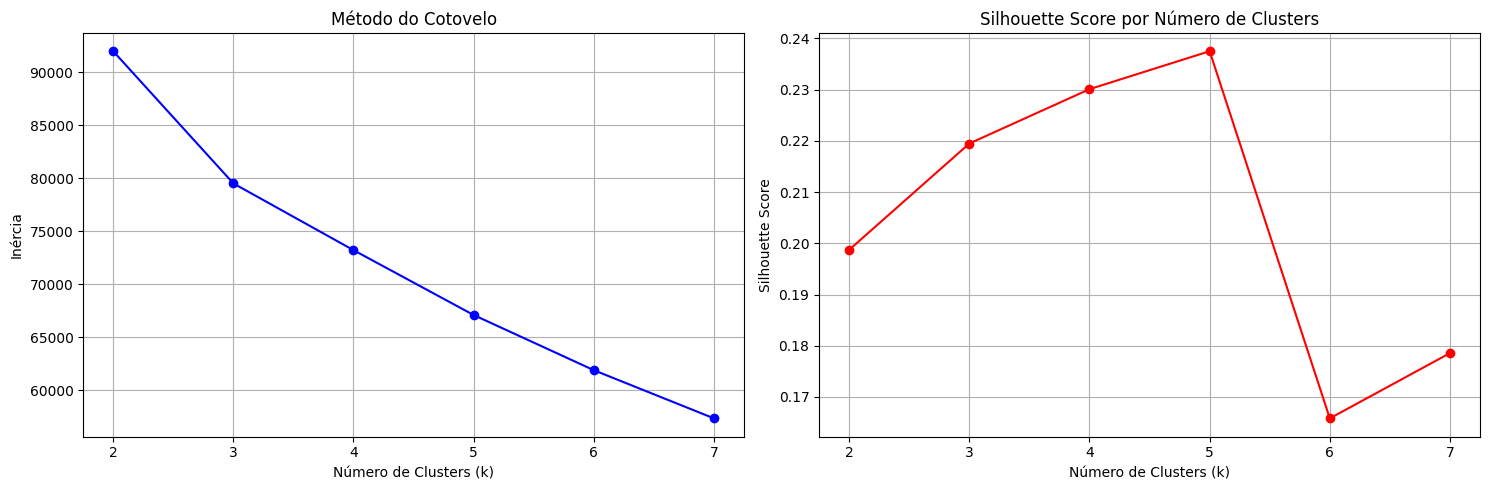


Melhor número de clusters: 5
Silhouette Score: 0.237


In [8]:
# Determinação do número ótimo de clusters
k_range = range(2, 8)

# Usar amostra para otimizar velocidade
sample_size = min(10000, len(cluster_data_scaled))
print(f"Determinando número ótimo de clusters usando amostra de {sample_size:,} registros...")

np.random.seed(42)
sample_idx = np.random.choice(len(cluster_data_scaled), size=sample_size, replace=False)
cluster_data_sample = cluster_data_scaled[sample_idx]

inertias = []
silhouette_scores = []

for k in k_range:
    print(f"Testando K={k}...")
    
    kmeans = KMeans(
        n_clusters=k, 
        random_state=42, 
        n_init=10,
        max_iter=300
    )
    kmeans.fit(cluster_data_sample)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(cluster_data_sample, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"  K={k}: Inércia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

# Plotar resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

best_k = k_range[np.argmax(silhouette_scores)]
print(f"\nMelhor número de clusters: {best_k}")
print(f"Silhouette Score: {max(silhouette_scores):.3f}")

In [9]:
# Treinamento do modelo final
print(f"Treinando modelo final com {best_k} clusters...")

dataset_size = len(cluster_data_scaled)


print(f"Dataset grande detectado ({dataset_size:,} registros)")
print("Usando estratégia otimizada: treinar em amostra, aplicar em batches")

# Treinar em amostra representativa
sample_size = 50000
sample_idx = np.random.choice(dataset_size, size=sample_size, replace=False)
cluster_data_sample = cluster_data_scaled[sample_idx]

final_kmeans = KMeans(
    n_clusters=best_k, 
    random_state=42, 
    n_init=10,
    max_iter=300
)
final_kmeans.fit(cluster_data_sample)

# Aplicar em batches
batch_size = 10000
total_batches = (dataset_size + batch_size - 1) // batch_size
cluster_labels = np.zeros(dataset_size, dtype=int)

for i in range(total_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, dataset_size)
    
    batch_data = cluster_data_scaled[start_idx:end_idx]
    batch_labels = final_kmeans.predict(batch_data)
    cluster_labels[start_idx:end_idx] = batch_labels
    
    if (i + 1) % 10 == 0:
        progress = (i + 1) / total_batches * 100
        print(f"Progresso: {progress:.1f}% concluído")
    

# Adicionar clusters ao dataset
customer_features['cluster'] = cluster_labels

# Calcular silhouette score final
if dataset_size > 50000:
    sil_sample_size = 10000
    sil_idx = np.random.choice(dataset_size, size=sil_sample_size, replace=False)
    final_silhouette = silhouette_score(cluster_data_scaled[sil_idx], cluster_labels[sil_idx])
else:
    final_silhouette = silhouette_score(cluster_data_scaled, cluster_labels)

print(f"\nTreinamento concluído!")
print(f"Silhouette Score final: {final_silhouette:.3f}")

# Distribuição dos clusters
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("\nDistribuição dos clusters:")
for i, count in cluster_counts.items():
    print(f"Cluster {i}: {count:,} clientes ({count/len(cluster_labels)*100:.1f}%)")

Treinando modelo final com 5 clusters...
Dataset grande detectado (581,817 registros)
Usando estratégia otimizada: treinar em amostra, aplicar em batches
Progresso: 16.9% concluído
Progresso: 33.9% concluído
Progresso: 50.8% concluído
Progresso: 67.8% concluído
Progresso: 84.7% concluído

Treinamento concluído!
Silhouette Score final: 0.226

Distribuição dos clusters:
Cluster 0: 362,459 clientes (62.3%)
Cluster 1: 116,961 clientes (20.1%)
Cluster 2: 65,895 clientes (11.3%)
Cluster 3: 9 clientes (0.0%)
Cluster 4: 36,493 clientes (6.3%)


In [10]:
# Análise e interpretação dos clusters
analysis_data = cluster_data.copy()
analysis_data['cluster'] = cluster_labels

# Estatísticas por cluster
cluster_summary = analysis_data.groupby('cluster').agg({
    'gmv_mean': ['mean', 'std'],
    'gmv_total': ['mean', 'std'],
    'purchase_count': ['mean', 'std'],
    'tickets_mean': ['mean', 'std'],
    'round_trip_rate': 'mean',
    'weekend_rate': 'mean',
    'avg_hour': 'mean'
}).round(2)

print("PERFIL DOS CLUSTERS")
print("=" * 50)

for cluster_id in range(best_k):
    cluster_data_subset = analysis_data[analysis_data['cluster'] == cluster_id]
    print(f"\nCLUSTER {cluster_id}:")
    print(f"Tamanho: {len(cluster_data_subset):,} clientes")
    print(f"GMV médio: R$ {cluster_data_subset['gmv_mean'].mean():.2f}")
    print(f"GMV total médio: R$ {cluster_data_subset['gmv_total'].mean():.2f}")
    print(f"Compras médias: {cluster_data_subset['purchase_count'].mean():.1f}")
    print(f"Taxa de ida e volta: {cluster_data_subset['round_trip_rate'].mean():.2f}")
    print(f"Taxa fim de semana: {cluster_data_subset['weekend_rate'].mean():.2f}")
    print(f"Horário médio: {cluster_data_subset['avg_hour'].mean():.1f}h")

print(f"\nResumo estatístico por cluster:")
print(cluster_summary)

PERFIL DOS CLUSTERS

CLUSTER 0:
Tamanho: 362,459 clientes
GMV médio: R$ 143.12
GMV total médio: R$ 288.91
Compras médias: 2.2
Taxa de ida e volta: 1.00
Taxa fim de semana: 0.08
Horário médio: 14.6h

CLUSTER 1:
Tamanho: 116,961 clientes
GMV médio: R$ 139.40
GMV total médio: R$ 265.89
Compras médias: 2.2
Taxa de ida e volta: 1.00
Taxa fim de semana: 0.89
Horário médio: 14.2h

CLUSTER 2:
Tamanho: 65,895 clientes
GMV médio: R$ 264.25
GMV total médio: R$ 1819.60
Compras médias: 9.5
Taxa de ida e volta: 1.00
Taxa fim de semana: 0.23
Horário médio: 14.5h

CLUSTER 3:
Tamanho: 9 clientes
GMV médio: R$ 260.21
GMV total médio: R$ 265164.29
Compras médias: 1019.1
Taxa de ida e volta: 1.00
Taxa fim de semana: 0.10
Horário médio: 13.9h

CLUSTER 4:
Tamanho: 36,493 clientes
GMV médio: R$ 544.22
GMV total médio: R$ 614.13
Compras médias: 1.1
Taxa de ida e volta: 1.00
Taxa fim de semana: 0.14
Horário médio: 14.9h

Resumo estatístico por cluster:
        gmv_mean          gmv_total           purchase_cou

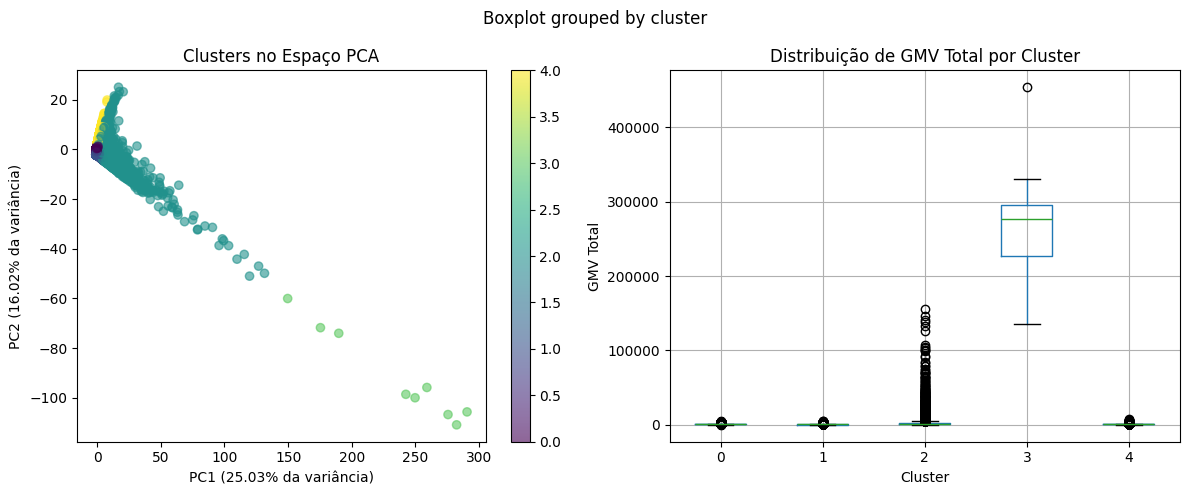

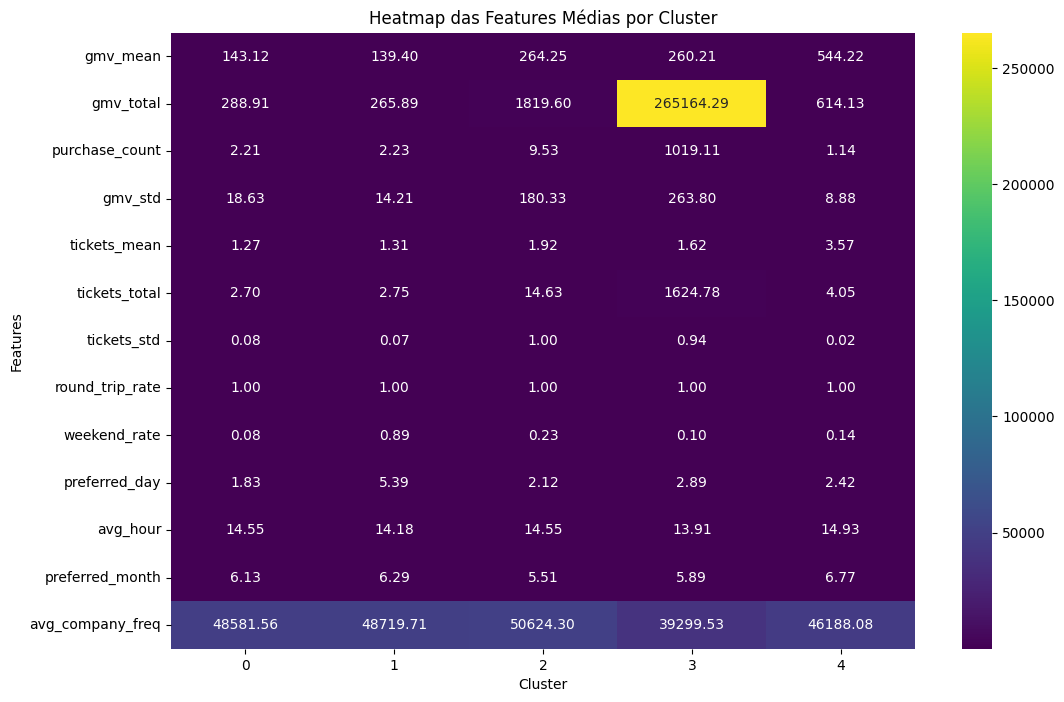

In [11]:
# Visualização dos clusters
# PCA para visualização em 2D
pca = PCA(n_components=2)
cluster_data_pca = pca.fit_transform(cluster_data_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} da variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} da variância)')
plt.title('Clusters no Espaço PCA')
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
analysis_data.boxplot(column='gmv_total', by='cluster', ax=plt.gca())
plt.title('Distribuição de GMV Total por Cluster')
plt.xlabel('Cluster')
plt.ylabel('GMV Total')

plt.tight_layout()
plt.show()

# Heatmap das features por cluster
plt.figure(figsize=(12, 8))
cluster_means = analysis_data.groupby('cluster').mean()
sns.heatmap(cluster_means.T, annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap das Features Médias por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()

In [12]:
# Exportação dos resultados
print("Exportando artefatos do modelo...")

# Criar estrutura de pastas
base_dir = 'dist/clusterization'
artifacts_dir = os.path.join(base_dir, 'artifacts')

os.makedirs(base_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)

print(f"Estrutura de pastas criada: {base_dir}/")

# 1. Salvar modelo e artefatos
print("\n1. Salvando modelo e componentes...")

model_artifacts = {
    'model': final_kmeans,
    'scaler': scaler,
    'feature_columns': clustering_features,
    'n_clusters': best_k,
    'trained_date': datetime.now(),
    'model_version': 'KMeans_v1.0',
    'performance_metrics': {
        'silhouette_score': round(final_silhouette, 4),
        'n_samples': len(cluster_labels),
        'inertia': round(final_kmeans.inertia_, 2)
    },
    'cluster_centers': final_kmeans.cluster_centers_.tolist(),
    'cluster_distribution': cluster_counts.to_dict()
}

# Salvar modelo
model_path = os.path.join(artifacts_dir, 'modelo_clusterizacao.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"Modelo salvo em: {model_path}")

# Salvar perfil dos clusters
cluster_summary_path = os.path.join(artifacts_dir, 'perfil_clusters.csv')
cluster_summary.to_csv(cluster_summary_path)
print(f"Perfil dos clusters salvo em: {cluster_summary_path}")

# 2. Criar dataset completo com clusters
print("\n2. Criando dataset com clusters...")

df_with_clusters = df.merge(customer_features[['fk_contact', 'cluster']], 
                           on='fk_contact', how='left')

# Adicionar informações do cluster
df_with_clusters['data_clusterizacao'] = datetime.now()
df_with_clusters['versao_modelo'] = 'KMeans_v1.0'

# Salvar dataset completo
csv_path = os.path.join(base_dir, 'dataset_com_clusters.csv')
df_with_clusters.to_csv(csv_path, index=False)

print(f"Dataset com clusters preparado: {df_with_clusters.shape[0]:,} registros")
print(f"Dataset salvo em: {csv_path}")

# 3. Criar metadados
print("\n3. Criando arquivo de metadados...")

metadata = {
    'projeto': 'Modelo de Clusterização - Segmentação de Clientes',
    'versao_modelo': 'KMeans_v1.0',
    'data_criacao': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'algoritmo': 'K-Means',
    'dataset': {
        'total_clientes': len(customer_features),
        'total_transacoes': len(df_with_clusters),
        'total_features': len(clustering_features),
        'features_utilizadas': clustering_features
    },
    'performance': {
        'silhouette_score': round(final_silhouette, 4),
        'n_clusters': best_k,
        'inertia': round(final_kmeans.inertia_, 2)
    },
    'distribuicao_clusters': {
        f'Cluster_{i}': int(count) for i, count in cluster_counts.items()
    },
    'arquivos_gerados': {
        'modelo_completo': 'artifacts/modelo_clusterizacao.pkl',
        'perfil_clusters': 'artifacts/perfil_clusters.csv',
        'dataset_csv': 'dataset_com_clusters.csv',
        'metadados': 'metadata.json'
    }
}

# Salvar metadados
metadata_path = os.path.join(base_dir, 'metadata.json')
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"Metadados salvos em: {metadata_path}")

print(f"\nDistribuição final dos clusters:")
for i, count in cluster_counts.items():
    pct = count/len(cluster_labels)*100
    print(f"  Cluster {i}: {count:6,} clientes ({pct:5.1f}%)")

print(f"\nPerformance do Modelo:")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Número de Clusters: {best_k}")
print(f"Total de Clientes Clusterizados: {len(customer_features):,}")

print(f"\nExportação concluída com sucesso!")

Exportando artefatos do modelo...
Estrutura de pastas criada: dist/clusterization/

1. Salvando modelo e componentes...
Modelo salvo em: dist/clusterization/artifacts/modelo_clusterizacao.pkl
Perfil dos clusters salvo em: dist/clusterization/artifacts/perfil_clusters.csv

2. Criando dataset com clusters...
Dataset com clusters preparado: 1,741,344 registros
Dataset salvo em: dist/clusterization/dataset_com_clusters.csv

3. Criando arquivo de metadados...
Metadados salvos em: dist/clusterization/metadata.json

Distribuição final dos clusters:
  Cluster 0: 362,459 clientes ( 62.3%)
  Cluster 1: 116,961 clientes ( 20.1%)
  Cluster 2: 65,895 clientes ( 11.3%)
  Cluster 3:      9 clientes (  0.0%)
  Cluster 4: 36,493 clientes (  6.3%)

Performance do Modelo:
Silhouette Score: 0.2256
Número de Clusters: 5
Total de Clientes Clusterizados: 581,817

Exportação concluída com sucesso!
